# Assignment 10: Regression with discrete variables
## Learning Outcomes:
This assignment introduces the use of discrete variables in regression analysis. Task 1 will use discrete variables as explanatory variables, in Task 2 we will use discrete variables as response variables and introduce logistic regression. 

## Data set 
Throught the assignment you will use the full possum.csv data set.  
The data set includes measures from 104 possums that were caught in New Zealand in a field study. 
Variables: 
-	site: The site number where the possum was trapped.
-	pop: Population, either Vic (Victoria) or other (New South Wales or Queensland).
-	sex: Gender, either m (male) or f (female).
-	age: Age in years
-	headL: Head length, in mm.
-	skullW: Skull width, in mm.
-	totalL: Total length, in cm.
-	tailL: Tail length, in cm.

## Preliminaries
Set up the environment by importing pandas, numpy, and matplotlib, scipy.optimize. This is already done in the preliminaries. Ensure that you have fully mastered all previous assignments (especially 8, 9) before starting the assignment. Import the regression functions that you used for the last homeworks. 

In [6]:
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt 
%matplotlib inline
import scipy.optimize as so
import pandas as pd 
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

## Task 1: Discrete predictor variables

### Question 1.1 (5 pt)
Load the data set possum.csv. 
Generate 3 new columns in the data frame: 
- bodyL: The length of the main body (totalL - tailL) 
- popI:  Population identifier, 0: if pop is 'other', 1: if pop is 'Vic'
- sexI:  Sex indentifier, 0: if sex is 'm', 1: if sex is 'f'

Use your function `multRegFit` from last homework to run a regression analysis of bodyL (response variable) against sexI (explanatory variable). Make a plot (with labeled axes) that show sex on the x-axis and body length on the y axis. Add the prediction line from the regression. 

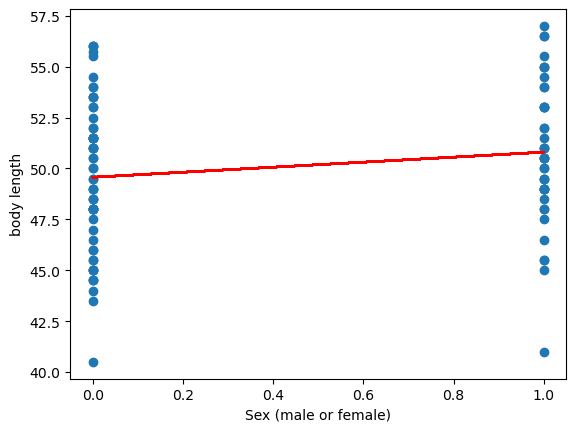

In [20]:
# load in data set
df = pd.read_csv("possum.csv")
df.columns

# generate 3 new columns
bodyL = df["totalL"] - df["tailL"]
tmp = df["pop"] == "Vic"
popI = np.double(tmp)
tmp2 = df["sex"] == "f"
sexI = np.double(tmp2)

# put into dataframe
df["bodyL"] = bodyL
df["popI"] = popI
df["sexI"] = sexI

# regression analysis of bodyL (y) and sexI (x)
def multRegPredict(b, D, xname):
    yp = np.ones(len(D.index))*b[0]        # Intercept 
    for i in range(len(xname)):          
        yp = yp + D[xname[i]]*b[i + 1]         # Add each regression value 
    return yp

def multRegLossRSS(b, D, y, xname):
    predY = multRegPredict(b, D, xname)
    res = y - predY
    rss = sum(res**2)
    grad = np.zeros(len(b))
    grad[0] = -2*np.sum(res)
    for i in range(len(xname)):
        grad[i+1] = -2*np.sum(D[xname[i]]*res)
    return (rss,grad)

def multRegFit(D, y, xname):
    N = len(xname)
    b0 = np.zeros((N + 1,))
    RES = so.minimize(multRegLossRSS, b0, args = (D, y, xname), jac=True)
    b = RES.x # Results
    res = y - np.mean(y)
    TSS = sum(res**2)
    RSS, deriv = multRegLossRSS(b, D, y, xname)
    R2 = 1 - RSS/TSS 
    return (R2, b)

# call function
R2, b = multRegFit(D = df, y = df["bodyL"], xname = ["sexI"])

# plotplot of sex vs body length
plt.scatter(df["sexI"], df["bodyL"])
plt.xlabel("Sex (male or female)")
plt.ylabel("body length")

# prediction line
yp = multRegPredict(b, df, ["sexI"])
plt.plot(df["sexI"], yp, 'r-')

plt.show()

Figure 1. Scatterplot of body length as explained by sex in a regression analysis

### Question 1.2 (10pt)
Use boostrap to estimate a 95% confidence interval on the regression parameter of sex as a explanatory variable for body length. Report the confidence interval. Can you reject the null-hypothesis that body length in possums does not differ between the sexes?  

In [21]:
def bootstrapReg(D, y, args, fitfcn = multRegFit, numIter = 500):
    R2, b = fitfcn(D, y, args)
    numParams = len(b)
    N = len(D.index)
    ind = np.arange(N)
    stats = np.zeros((numIter, numParams))
    for i in range(numIter):
        sample = np.random.choice(ind, N)
        R2, stats[i,: ] = fitfcn(D.iloc[sample], y[sample], args)
    return stats

def confidenceInt(data, perc):
    tail = (100 - perc)/2 # Weight on each tail  
    Int = (np.percentile(data,tail), np.percentile(data, 100 - tail))
    return Int

# call bootstrap to estimate 95% CI
B = bootstrapReg(df, df["bodyL"], ["sexI"])
confidenceInt(data = B, perc = 0.95)
    

(2.7523556210288995, 48.52747986505682)

The confidence interval is (2.96, 48.35), which does not include zero, so sex does not influence body length and we fail to reject the null hypothesis.

### Question 1.3 (10pt)
Make a plot plot of age (x-axis) against body length (y-axis), with male and female possums shown in different colors. 
You can do this by plotting two plot plots sequentially - each time selecting either male or female possums. The second one will simply add points in a different color to the first plot.  

Estimate a multiple regression model that explains bodyL as a function of age and sex. What is the R2-value? 

Get the predicted values from the regression, and plot the predicted values in the same graph seperately for male and female possums. 

0.08543037213506455

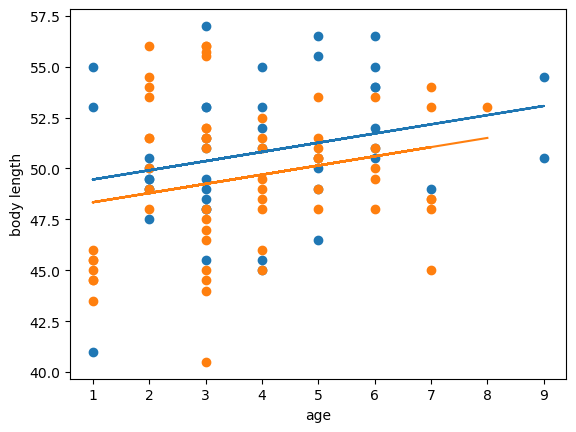

In [22]:
# Scatterplot, 1 = female, 0 = male
plt.scatter(df["age"].loc[df["sexI"] == 1], df["bodyL"].loc[df["sexI"] == 1])
plt.scatter(df["age"].loc[df["sexI"] == 0], df["bodyL"].loc[df["sexI"] == 0])

plt.xlabel("age")
plt.ylabel("body length")

# multiple regression model
R2, b = multRegFit(D = df, y = df["bodyL"], xname = ["age", "sexI"])
display(R2)

# predicted values from regression
yp = multRegPredict(b, df, ["age", "sexI"])
plt.plot(df["age"].loc[df["sexI"] == 1], yp[df["sexI"] == 1])
plt.plot(df["age"].loc[df["sexI"] == 0], yp[df["sexI"] == 0])
plt.show()

Figure 2. Scatterplot of body length as a function of age and sex in a regression model.

The R-squared value is 0.085.

### Question 1.4 (7pt)
Run a bootstrap analysis on the bodyL ~ age + sexI regression model. Report the 95% confidence interval for the regression parameters of sex and age on body length. How big is the effect of age onto body length in the context of the model? Does the confidence interval for the parameter include 0?


How big is the estimate of the effect of sex on body length? What is the CI? Does it include zero?   


In [57]:
# bootstrap call
vals = bootstrapReg(df, df["bodyL"], ["age", "sexI"])
# display(vals)

# CI for age and sexI
CI_age = confidenceInt(data = vals[:, 1], perc = 0.95)
CI_sex = confidenceInt(data = vals[:, 2], perc = 0.95)

display(CI_age)
display(CI_sex)

(0.4543808911196642, 0.45684893781955244)

(1.0331009502181794, 1.053439652271693)

Age has no effect on body length. The CI is small, CI = (0.454, 0.457) and does not include 0.

Sex has no effect on body length. The CI is small, CI = (1.033, 1.0534), which doesn't include zero.

### Question 1.5 (10pt)
Estimate a multiple regression model that explains bodyL as a function of age and population (Vic vs. other). What is the R2-value? Make a plot plot like for Question 3, but this time splitting the data for the two populations, rather than based on sex. 

Which of the two population (Vic or other) has a larger mean body size? What is the mean differences in body size?  

In contrast to simple mean difference in body size, how do you interpret the value of the regression coefficient for popI?  

0.1797451784949856

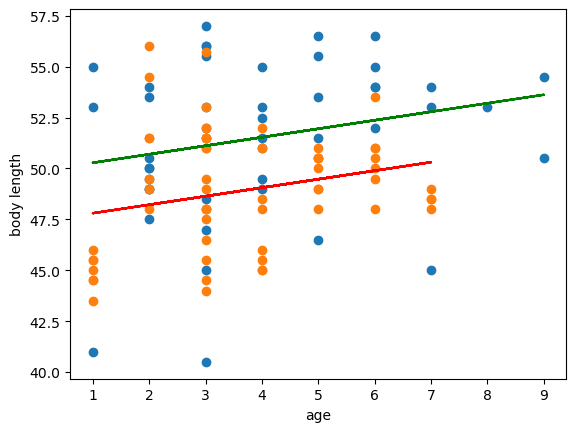

In [23]:
# plotplot, 1 = female, 0 = male
plt.scatter(df["age"].loc[df["popI"] == 1], df["bodyL"].loc[df["popI"] == 1])
plt.scatter(df["age"].loc[df["popI"] == 0], df["bodyL"].loc[df["popI"] == 0])

plt.xlabel("age")
plt.ylabel("body length")

# multiple regression model
R2, b = multRegFit(D = df, y = df["bodyL"], xname = ["age", "popI"])
display(R2)

# predicted values from regression
yp = multRegPredict(b, df, ["age", "popI"])
plt.plot(df["age"].loc[df["popI"] == 1], yp[df["popI"] == 1], "g-")
plt.plot(df["age"].loc[df["popI"] == 0], yp[df["popI"] == 0], "r-")
plt.show()

Figure 3. Scatterplot of body length as a function of age and 
population in a regression model.

In [52]:
# simple mean difference in body size
newdf = df[["sex", "bodyL"]].groupby("sex").mean()
display(newdf)

meanDiff = newdf["bodyL"].loc[newdf.index[0]] - newdf["bodyL"].loc[newdf.index[1]]
print("simple mean difference is: ", meanDiff)

,bodyL
sex,
f,50.802326
m,49.568852


simple mean difference is:  1.2334731223789603


R-squared = 0.180. Population Vic has a larger mean body size. The mean difference in body size is 1.233.

In [70]:
R2, b = multRegFit(D = df, y = df["bodyL"], xname = ["age", "popI"])
b

array([47.3855543 ,  0.41746659,  2.47718803])

Regression coefficient for popI is 2.477, which is the slope for popI.

### Question 1.6 (8pt)
Run a bootstrap analysis on the bodyL ~ age + popI regression model. Report the 95% confidence interval for the regression parameters of popI and age on body length. In the conext of the model, is there evidence for a positive effect of age onto body length? How about the relationship between population and body length? 


In [71]:
# bootstrap call
vals = bootstrapReg(df, df["bodyL"], ["age", "popI"])
# display(vals)

# CI for age and sexI
CI_age = confidenceInt(data = vals[:, 1], perc = 0.95)
CI_pop = confidenceInt(data = vals[:, 2], perc = 0.95)

display(CI_age)
display(CI_pop)

(0.40446519357771205, 0.4090166906114919)

(2.48851671811694, 2.514640410216257)

Age has no effect on body length. The CI is small, CI = (0.418, 0.421) and does not include 0.

Pop has no effect on body length. The CI is small, CI = (2.530, 2.543), which doesn't include zero.

There is no evidence for a positive effect of age on body length. 
There is no evidence for a positive effect of population on body length.

## Task 2: Discrete response variable
In this task we will investigate regression models in which the response variable is a discrete, dichotomous variable. 
### Question 2.1: Logistic Function (10pt)
Starting with your function for multRegPredict, write a function logisticRegPredict(b,D,xname). As inputs it should take the 
- b: np-array of regression coefficients (the first one being the intercept)
- D: Data frame
- xname: a list of column names (in D) that are being used as regressors. 

The function should first calculate a = b[0] + b[1] * D[xname[0]] + b[2] * D[xname[1]] 
and then return the logistic function of a. 

Then make a Data frame with a single column with the values from -4 to 4 (in small steps). Plot the logistic function for the parameter values: 
- b = [0,0]
- b = [0,1]
- b = [0,2]
- b = [0,-2]

What happens as the slope value changes? 

Then plot the logistic function for the parameter values: 
- b = [0,2]
- b = [1,2]
- b = [2,2]
- b = [-2,2]

What happens as the intercept value changes? For each value - where does the predicted line cross p=0.5? 



In [12]:
def logisticRegPredict(b, D, xname):
    # b      parameters
    # D      dataframe
    # xname  names of the explanatory variables

    an = np.ones(len(D.index))*b[0]        # Intercept 
    
    for i in range(len(xname)):          
        an = an + D[xname[i]]*b[i + 1]         # Add each regression value 
    
    # logistic function
    pn = 1 / ( 1 + np.exp(-1*an))
    return pn

In [1]:
# dummy df
data = np.linspace(-4, 4, num = 50)
dummy = pd.DataFrame(data, columns = ["values"])
dummy

NameError: name 'np' is not defined

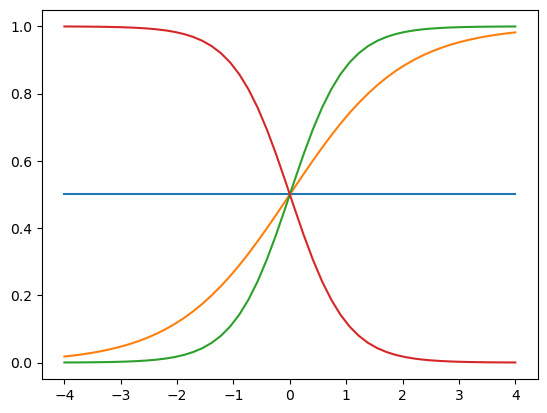

In [27]:
pn1 = logisticRegPredict(b = [0, 0], D = dummy, xname = ["values"])
pn2 = logisticRegPredict(b = [0, 1], D = dummy, xname = ["values"])
pn3 = logisticRegPredict(b = [0, 2], D = dummy, xname = ["values"])
pn4 = logisticRegPredict(b = [0, -2], D = dummy, xname = ["values"])

plt.plot(data, pn1)
plt.plot(data, pn2)
plt.plot(data, pn3)
plt.plot(data, pn4)
plt.show()

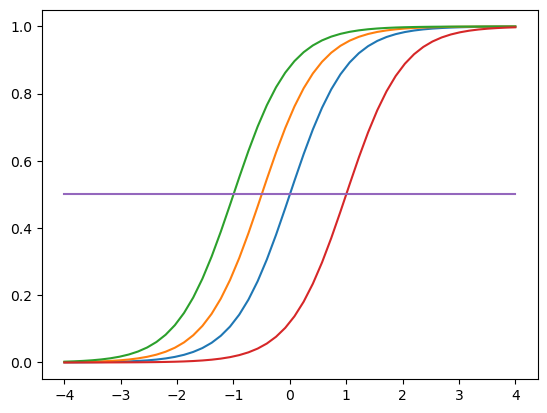

In [26]:
pn5 = logisticRegPredict(b = [0, 2], D = dummy, xname = ["values"])
pn6 = logisticRegPredict(b = [1, 2], D = dummy, xname = ["values"])
pn7 = logisticRegPredict(b = [2, 2], D = dummy, xname = ["values"])
pn8 = logisticRegPredict(b = [-2, 2], D = dummy, xname = ["values"])

# p = 0.5
pn1 = logisticRegPredict(b = [0, 0], D = dummy, xname = ["values"])

plt.plot(data, pn5)
plt.plot(data, pn6)
plt.plot(data, pn7)
plt.plot(data, pn8)
plt.plot(data, pn1)
plt.show()

As the intercept increases, the predicted line crosses p = 0.5 at a larger and larger x-value.

### Question 2.2 (10pt)
Make a Scatterplot of tail length (as a x-variable) against popI (Population, 1:Victoria 0:other). 
Written answer: What relationship can you see? 


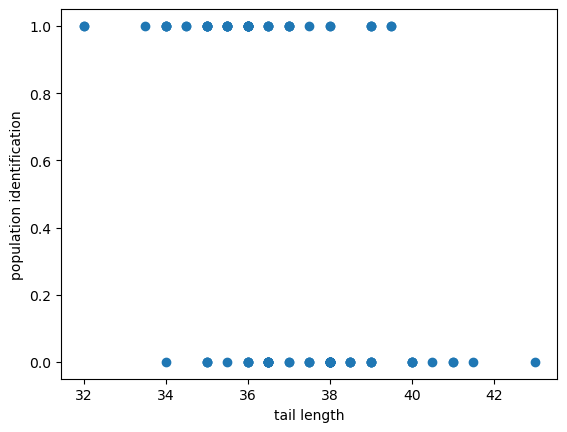

In [96]:
plt.scatter(df["tailL"], df["popI"])
plt.xlabel("tail length")
plt.ylabel("population identification")
plt.show()

We observe that population Vic tends to have smaller tail length compared to population other.

### Question 2.3 (10pt)
Write a function logisticRegLoss(b,D,y,name) that calculates the Loss function for the logistic regression (negative log-likelihood, see lecture). The function should call logisticRegPredict to get the prediction, and then calculate the Loss and the derivative of the loss in respect to all regression paramaters. The function should be able to use multiple regressors (like multRegLossRSS from previous homeworks).    

Report the negative log likelihood (and derivates) for a logistic regression model that predicts popI as a function of tailL: 
- for the parameter values [0,0]
- for the parameter values [17.5,-0.5]
- for the parameter values [25.56,-0.7]

Which one is the best parameter setting of the three? 

In [13]:
# loss function
def logisticRegLoss(b, D, y, xname):
    p = logisticRegPredict(b, D, xname)
    loss = -1*(np.sum(y*np.log(p) + (1 - y)*np.log(1 - p))) # negative log-likelihood
    N = len(xname)
    grad = np.zeros(N + 1)
    res = y - p
    grad[0] = -1*(np.sum(res))  # gradient for b0
    for i in range(N):
        grad[i+1] = -1*(np.sum(D[xname[i]]*res))    # gradient for b1, b2, ...
    return (loss, grad)

In [14]:
logisticRegLoss([0, 0], df, df["popI"], ["tailL"])

(72.0873067782343, array([  6. , 271.5]))

In [15]:
logisticRegLoss([17.5, -0.5], df, df["popI"], ["tailL"])

(63.01497836859197, array([ -14.65999642, -527.46450906]))

In [28]:
logisticRegLoss([25.56,-0.7], df, df["popI"], ["tailL"])

(56.72412770882329, array([ -0.37160079, -13.678462  ]))

The better model has higher log-likelihood, so the best model is the one with parameter setting [25.56, -0.7]. 

### Question 2.4 (10pt)
Write a function logisticRegFit(D,y,xname,figure=True) that fits the logistic model by minimizing the above Loss function. 
- D: A data frame with the explanatory variables 
- y: A dichotomous (0 or 1) response variable 
- xname: Names of x variables to be used 
- figure: Flag (True / False) indicating if the code should produce a figure. 
When there is only one x-variable, and figure==True, then function should produce a scatter plot of the data and the predicted values. 

The function should return the log-likelihood of the data under the best model and the best fitting (maximum liklihood) estimates of b. Remember that the function value you are minimizing is the *negative* log-likelihood, and the best fitting value is stored in RES.fun

Fit a logistic regression model that predicts popI as a function of tailL. Make sure the function generates a plot. Report log-likelihood and b-values. 

In [43]:
def logisticRegFit(D, y, xname, figure = True):
    N = len(xname)
    b0 = np.zeros((N + 1,))
    RES = so.minimize(logisticRegLoss, b0, args = (D, y, xname), jac=True)
    b = RES.x # Results
    
    loss, grad = logisticRegLoss(b, D, y, xname)
    logLike = -1*loss   # loss is negative log-likelihood

    if figure == True:
        plt.scatter(D[xname[0]], y)
        x = np.linspace(np.min(D[xname[0]]), np.max(D[xname[0]]))
        yp = b[0] + b[1]*x
        pn = 1 / (1 + np.exp(-yp))

        plt.plot(x, pn, "r-")

    return (logLike, b)

(-56.72051579544121, array([25.56620437, -0.69964061]))

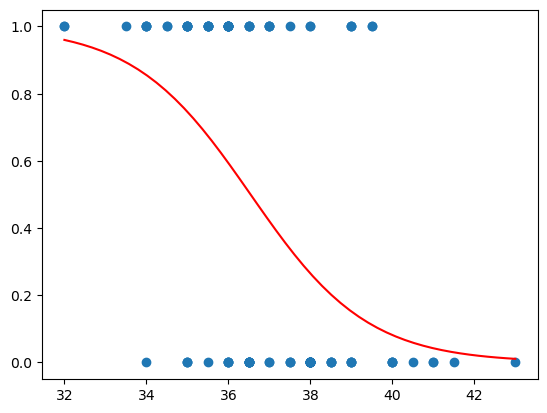

In [44]:
logisticRegFit(df, df["popI"], ["tailL"])
# graph should have scatter and fitted line

The log-likelihood is -56.721 and the b-values are 25.566 and -0.700.

### Question 2.5 (10pt)
Now fit the model explaing popI from tailL and bodyL in a multiple logistic regression model. Report the log-likelihood and parameter values. Is the fit better than tailL alone? 

Also fit the model explaing popI from tailL and totalL in a multiple logistic regression model. Again, report the log-likelihood and parameter values. 

What do you observe in terms of log-likelihood and in terms of paramters? Why do these two models yield exactly the same log-liklihood? 

In [45]:
logisticRegFit(df, df["popI"], ["tailL", "bodyL"], figure = False)

(-43.20463551583587, array([16.57735312, -0.98846114,  0.39180167]))

In [46]:
logisticRegFit(df, df["popI"], ["tailL", "totalL"], figure = False)

(-43.20463551583589, array([16.5773531 , -1.38026281,  0.39180168]))

The log-likelihood for tailL and bodyL is -43.20463551583587, the parameter values are 16.577, -0.988, and 0.393. The fit is better than tail alone.

The log-likelihood for tailL and totalL is -43.20463551583589, the parameter values are 16.577, -1.380, and 0.392.

The log-likelihood and first parameter (intercept) are the same for both, the last parameter is very close as well.

The log-likelihoods are the exact same because the loss is calculated using the same p and y.